In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import yfinance as yf
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator

from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

from datetime import datetime, timedelta, time

In [2]:
# Fetch and prepare data
btc = yf.download('BTC-USD', start='2015-01-01', end=pd.Timestamp.today().strftime('%Y-%m-%d'))

btc = btc.reset_index()  # Make Date a regular column
btc.columns = btc.columns.droplevel(1)  # Remove the Ticker level from column
btc = btc.rename(columns={'Close':'price', 'Date':'date', 'Volume':'volume'})  # Rename Price

btc = btc[['date', 'price', 'volume']]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
# Simple Moving Average
window = 14
#btc['sma_14'] = SMAIndicator(btc['close'], window=window).sma_indicator()

# Relative Strength Index
btc['rsi_14'] = RSIIndicator(btc['price'], window=window).rsi()

# Price change percentages
btc['daily_pct_change'] = btc['price'].pct_change()

# Rolling statistics
btc['rolling_mean_7'] = btc['price'].rolling(window=7).mean()
btc['rolling_std_7'] = btc['price'].rolling(window=7).std()

# Drop NaN values
btc = btc.dropna()

In [4]:
# Prepare data for modeling
forecast_horizon = 1

# Target is the future price
btc['target'] = btc['price'].pct_change()

# Remove rows where target is NaN (end of dataset)
btc = btc.dropna()

In [5]:
#Fear and Greed Index data
import requests
from io import StringIO

#source: https://alternative.me/crypto/fear-and-greed-index/
url = 'https://api.alternative.me/fng/?limit=0'
response = requests.get(url)

if response.status_code == 200:
    data_r = response.json()
    df_response = pd.DataFrame(data_r['data'])

    # Convert and format columns
    df_response['date'] = pd.to_datetime(df_response['timestamp'], unit='s')
    df_response = df_response[['value', 'value_classification', 'date']] \
         .rename(columns={
             'value': 'fng_value',
             'value_classification': 'classification'
         })

    df_response = df_response[['fng_value', 'date']]
    print(df_response.head(10))
    
else:
    print(f"Error: {response.status_code}")

  fng_value       date
0        68 2025-06-17
1        61 2025-06-16
2        60 2025-06-15
3        63 2025-06-14
4        61 2025-06-13
5        71 2025-06-12
6        72 2025-06-11
7        71 2025-06-10
8        62 2025-06-09
9        62 2025-06-08


C:\Users\joseh\AppData\Local\Temp\ipykernel_26004\1996290388.py:14: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_response['date'] = pd.to_datetime(df_response['timestamp'], unit='s')


In [6]:
df_response['fng_value'] = df_response['fng_value'].apply(lambda x: float(x))
fng_df = df_response.copy()
fng_df.tail(10)

,fng_value,date
2680,54.0,2018-02-10
2681,44.0,2018-02-09
2682,30.0,2018-02-08
2683,36.0,2018-02-07
2684,8.0,2018-02-06
2685,11.0,2018-02-05
2686,24.0,2018-02-04
2687,40.0,2018-02-03
2688,15.0,2018-02-02
2689,30.0,2018-02-01


In [7]:
data_2018 = btc.merge(fng_df, on='date', how='outer')  #merge
data_2018 = data_2018.dropna()
data_2018.head()

,date,price,volume,rsi_14,daily_pct_change,rolling_mean_7,rolling_std_7,target,fng_value
1113,2018-02-01,9170.540039,9.959400e+09,32.505630,-0.102783,10741.820033,932.329222,-0.102783,30.0
1114,2018-02-02,8830.750000,1.272690e+10,31.214760,-0.037052,10407.441406,1147.490929,-0.037052,15.0
1115,2018-02-03,9174.910156,7.263790e+09,34.070623,0.038973,10083.757115,1126.833433,0.038973,40.0
1116,2018-02-04,8277.009766,7.073550e+09,30.511391,-0.097865,9582.429967,1018.569546,-0.097865,24.0
1117,2018-02-05,6955.270020,9.285290e+09,26.176396,-0.159688,8962.268485,1117.808604,-0.159688,11.0


In [8]:
data_2018.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2689 entries, 1113 to 3805
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              2689 non-null   datetime64[ns]
 1   price             2689 non-null   float64       
 2   volume            2689 non-null   float64       
 3   rsi_14            2689 non-null   float64       
 4   daily_pct_change  2689 non-null   float64       
 5   rolling_mean_7    2689 non-null   float64       
 6   rolling_std_7     2689 non-null   float64       
 7   target            2689 non-null   float64       
 8   fng_value         2689 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 210.1 KB


In [9]:
# Features and target
X = data_2018.drop(columns=['target', 'date', 'price', 'daily_pct_change'])
y = data_2018['target']

In [10]:
# Train XGBoost model
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [11]:
cv_params = {'max_depth': [4, 6],
             'min_child_weight': [3, 5],
             'learning_rate': [0.001, 0.01, 0.1],
             'n_estimators': [1000, 2000],
             'subsample': [0.6, 0.8],
             'colsample_bytree': [0.7]
            }

In [12]:
cv_params = {'max_depth': [16],
             'min_child_weight': [3],
             'learning_rate': [0.1],
             'n_estimators': [1000, 3000],
             'subsample': [1.0],
             'colsample_bytree': [0.7]
            }

In [13]:
scoring = {'r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'}

In [14]:
"""
# Create XGBoost model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.001,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=50,
    random_state=42
)
"""

"\n# Create XGBoost model\nmodel = xgb.XGBRegressor(\n    objective='reg:squarederror',\n    n_estimators=1000,\n    learning_rate=0.001,\n    max_depth=4,\n    subsample=0.8,\n    colsample_bytree=0.8,\n    early_stopping_rounds=50,\n    random_state=42\n)\n"

In [15]:
# Create XGBoost model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    #early_stopping_rounds=50,
    random_state=42
)

In [16]:
xgb_cv = GridSearchCV(model,
                      cv_params,
                      scoring = 'neg_mean_squared_error',
                      cv = 5,
                      verbose = 1
                     )

In [17]:
%%time

# Train model
xgb_cv.fit(
    X_train, y_train,
    #eval_set=[(X_test, y_test)],
    verbose=1
)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: total: 2min 52s
Wall time: 50.2 s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.1],
                         'max_depth': [16], 'min_child_weight': [3],
                         'n_estimators': [1000, 3000], 'subsample': [1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [18]:
"""
# Train model
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=1
)
"""
#plot_importance(xgb_cv.best_estimator_)
xgb_cv.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 16,
 'min_child_weight': 3,
 'n_estimators': 1000,
 'subsample': 1.0}

In [19]:
predictions = xgb_cv.predict(X_test)
print(predictions[-10:])

print(mean_squared_error(y_test, predictions))

[ 0.00196892 -0.00165675  0.01169424  0.00045977  0.00408844 -0.01246881
 -0.01053903  0.00798643  0.00529373 -0.0083066 ]
0.0007014281222440044


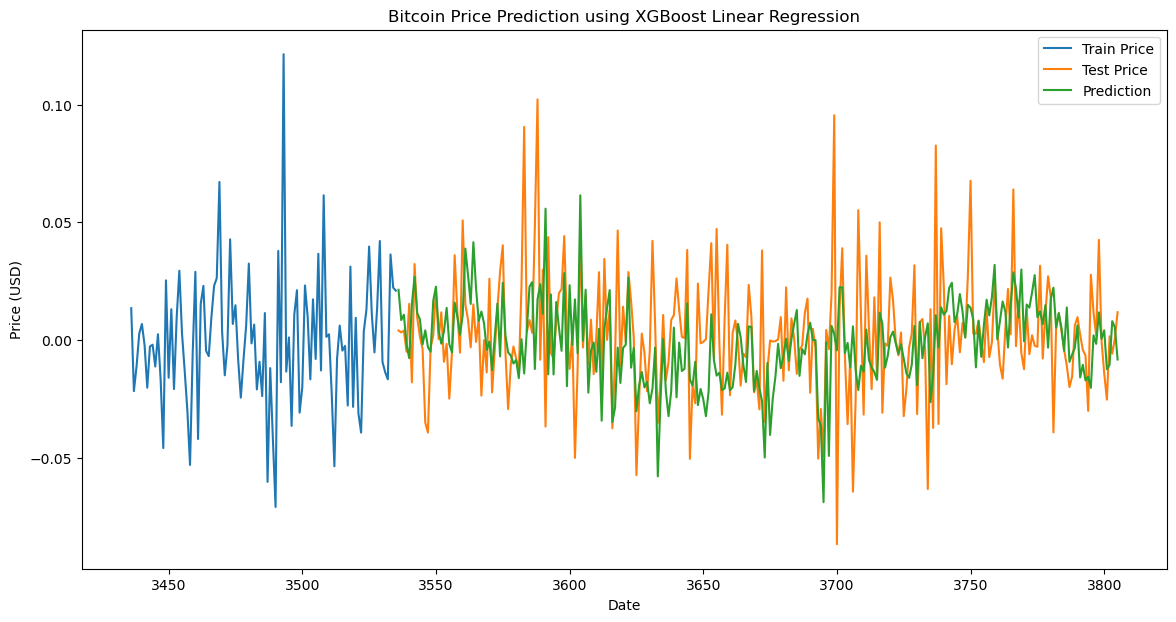

In [20]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot baseline and predictions
plt.plot(y_train.index[-100:], y_train[-100:], label='Train Price')
plt.plot(y_test.index, y_test, label='Test Price')
plt.plot(y_test.index, predictions, label='Prediction')
plt.title('Bitcoin Price Prediction using XGBoost Linear Regression')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

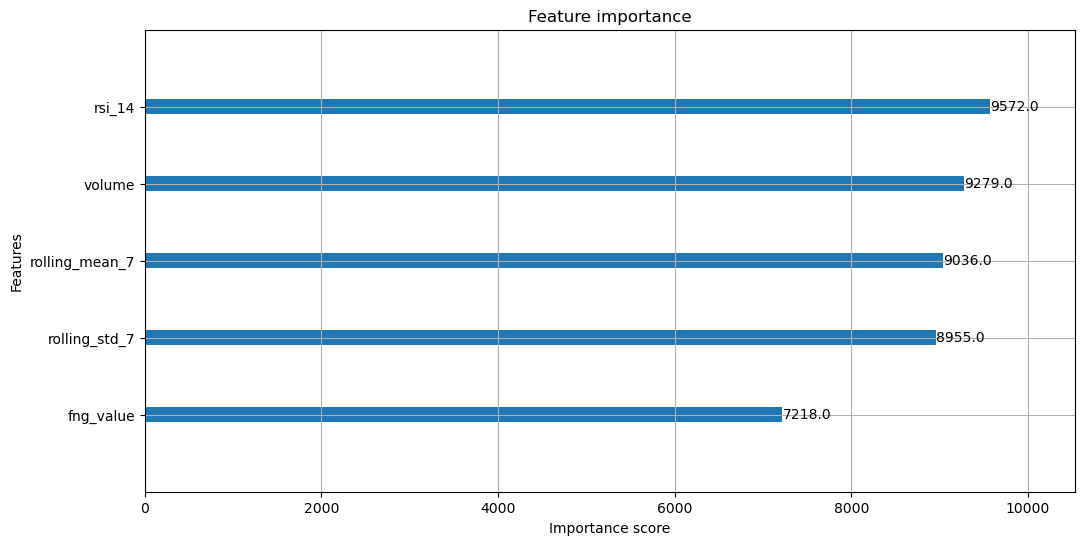

In [21]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(xgb_cv.best_estimator_, max_num_features=8, ax=ax)
plt.show();

In [22]:
features = data_2018.drop(columns=['target', 'date', 'price', 'daily_pct_change']).columns
print(features)

Index(['volume', 'rsi_14', 'rolling_mean_7', 'rolling_std_7', 'fng_value'], dtype='object')


In [23]:
import random

# Make future predictions
days_to_predict = 10

#data_sequence = data_2018.loc[data_2018.index[-1], features].copy()
#data_sequence = pd.DataFrame(data_sequence).transpose().reset_index().drop(columns=['index'])
data_sequence = data_2018.drop(columns=['target', 'date', 'price', 'daily_pct_change']).copy()
data_full = data_2018.copy()

# Create a copy of the last available data point
#last_data = btc.iloc[-1:].copy()
#last_data = last_data.reset_index()
#last_data = last_data.drop(columns=['date'])

predictions = []
dates = []

#Create dataframe for days_to_predict
for i in range(days_to_predict):
    last_row = data_sequence.iloc[-1:].copy()
    #print(last_row)

    #get prediction for the day
    pred = xgb_cv.predict(last_row)[0]
    print(pred)

    #add predicted target to full_data
    last_price = data_full.loc[data_full.index[-1], 'price']

    print(pd.to_datetime(data_full.loc[data_full.index[-1], 'date']).timestamp())
    last_date = pd.to_datetime(data_full.loc[data_full.index[-1], 'date']).timestamp()
    next_date = last_date + 86400 #Add a day to timestamp
    next_date = pd.to_datetime(next_date, unit='s')

    predictions.append((1 + pred) * last_price)
    dates.append(next_date)
    
    predicted_row = pd.DataFrame({'target': [pred], 
                                  'rsi_14': [0], 
                                  'volume': [data_full['volume'].iloc[-2 +i]], 
                                  'rolling_mean_7': [0], 
                                  'rolling_std_7': [0], 
                                  'fng_value': [data_full['fng_value'].iloc[-2 +i]], 
                                  'daily_pct_change': [pred], 
                                  'date': [next_date],
                                  'price': [(1 + pred) * last_price]})
    data_full = pd.concat([data_full, predicted_row], ignore_index=True)
    
    #calculate metrics
    data_full.loc[data_full.index[-1], 'volume'] = data_full['volume'].iloc[-2 +i]
    
    data_full['rsi_14'] = RSIIndicator(data_full['price'], window=window).rsi()
    data_full['rolling_mean_7'] = data_sequence['rolling_mean_7'].rolling(window=7).mean()
    data_full['rolling_std_7'] = data_sequence['rolling_std_7'].rolling(window=7).std()

    data_full.loc[data_full.index[-1], 'fng_value'] = data_full['fng_value'].iloc[-2 +i]

    #update data_sequence
    last_entry_df = pd.DataFrame(data_full.drop(columns=['target', 'date', 'price', 'daily_pct_change']).iloc[-1]).transpose()
    data_sequence = pd.concat([data_sequence, last_entry_df], ignore_index=True)
    #print(data_sequence)
    

-0.008306598
1750032000.0
-0.0009846017
1750118400.0
-0.017000398
1750204800.0
-0.018923227
1750291200.0
0.017375689
1750377600.0
0.0163996
1750464000.0
-0.010608276
1750550400.0
0.027059214
1750636800.0
0.020760968
1750723200.0
0.0077314046
1750809600.0


In [24]:
pd.DataFrame(data_full.iloc[-1]).transpose()

,date,price,volume,rsi_14,daily_pct_change,rolling_mean_7,rolling_std_7,target,fng_value
2698,2025-06-26 00:00:00,110291.604774,9346750464.0,61.662998,0.007731,NaN,NaN,0.007731,30.0


In [25]:
len(predictions)
predictions[0:4]

[105909.6400465916, 105805.36123744801, 104006.62802108025, 102038.48701616509]

In [26]:
future_df = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predictions
})

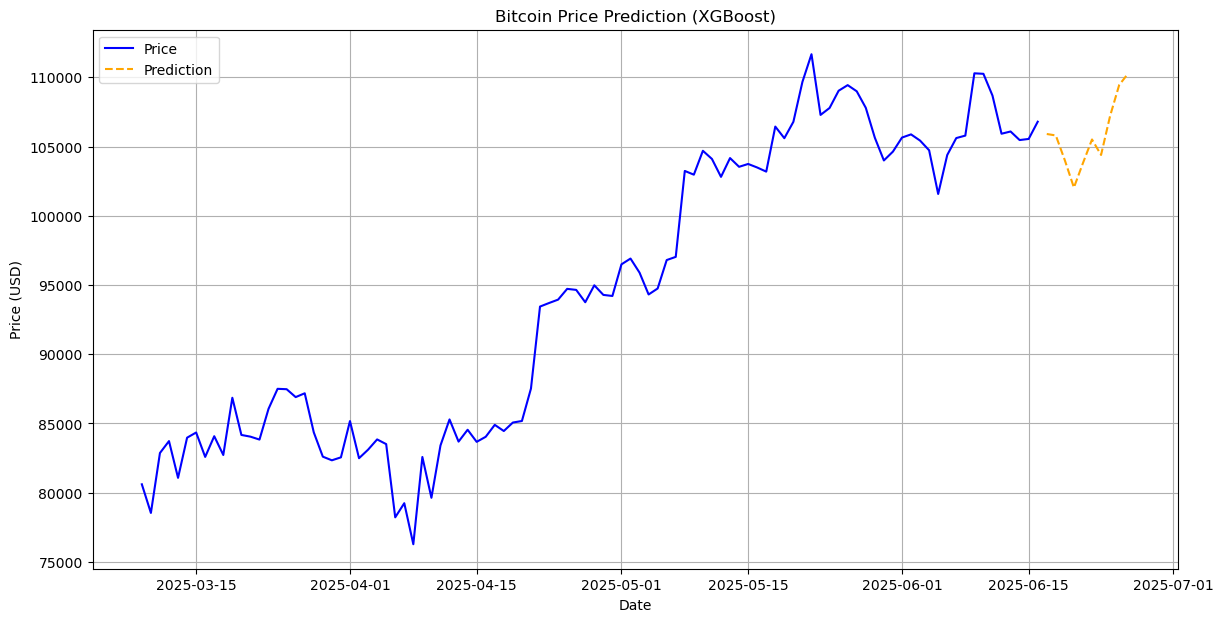

In [27]:
# Create dates for future predictions
last_date = btc.index[-1]
future_dates = pd.date_range(start=last_date, periods=len(predictions) +1)[1:]

# Plot results
plt.figure(figsize=(14, 7))
#plt.plot(data_2018.index[-100:], data_2018['target'][-100:], label='Historical Price')
#plt.plot(future_dates, predictions, label='60-day Prediction', linestyle='--', color='orange')
plt.plot(data_2018['date'][-100:], data_2018['price'][-100:], label='Price', color='blue')
plt.plot(future_df['Date'], future_df['Predicted_Price'], label='Prediction', linestyle='--', color='orange')
plt.title('Bitcoin Price Prediction (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

In [28]:
# Print predictions
print("\nPredicted Bitcoin Prices for Next 60 Days:")
for i, (date, price) in enumerate(zip(dates, predictions), 1):
    print(f"Day {i:2d} ({date.strftime('%Y-%m-%d')}): ${price:,.2f}")


Predicted Bitcoin Prices for Next 60 Days:
Day  1 (2025-06-17): $105,909.64
Day  2 (2025-06-18): $105,805.36
Day  3 (2025-06-19): $104,006.63
Day  4 (2025-06-20): $102,038.49
Day  5 (2025-06-21): $103,811.48
Day  6 (2025-06-22): $105,513.94
Day  7 (2025-06-23): $104,394.62
Day  8 (2025-06-24): $107,219.46
Day  9 (2025-06-25): $109,445.44
Day 10 (2025-06-26): $110,291.60


In [29]:
future_df

,Date,Predicted_Price
0,2025-06-17,105909.640047
1,2025-06-18,105805.361237
2,2025-06-19,104006.628021
3,2025-06-20,102038.487016
4,2025-06-21,103811.476033
5,2025-06-22,105513.942675
6,2025-06-23,104394.621612
7,2025-06-24,107219.458038
8,2025-06-25,109445.437811
9,2025-06-26,110291.604774


In [30]:
future_df.to_csv('xgboost_btc_price.csv', index=False)